In [1]:
from torchvision import transforms as T
import matplotlib.pyplot as plt
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch
import torch.nn as nn
import torch.nn.functional as F
from functools import reduce
import torch.optim as optim

In [2]:
##############################
# Look Train and Test Classes
##############################
train_data = ImageFolder('../Dataset/Train')
test_data = ImageFolder('../Dataset/Test')

print("Train Classes")
print(train_data.class_to_idx)
print("Test Classes")
print(test_data.class_to_idx)


Train Classes
{'0': 0, '1': 1, '10': 2, '11': 3, '12': 4, '13': 5, '14': 6, '15': 7, '16': 8, '17': 9, '18': 10, '19': 11, '2': 12, '20': 13, '21': 14, '22': 15, '23': 16, '24': 17, '25': 18, '26': 19, '27': 20, '28': 21, '29': 22, '3': 23, '30': 24, '31': 25, '32': 26, '33': 27, '34': 28, '35': 29, '36': 30, '37': 31, '38': 32, '39': 33, '4': 34, '40': 35, '41': 36, '42': 37, '5': 38, '6': 39, '7': 40, '8': 41, '9': 42}
Test Classes
{'0': 0, '1': 1, '10': 2, '11': 3, '12': 4, '13': 5, '14': 6, '15': 7, '16': 8, '17': 9, '18': 10, '19': 11, '2': 12, '20': 13, '21': 14, '22': 15, '23': 16, '24': 17, '25': 18, '26': 19, '27': 20, '28': 21, '29': 22, '3': 23, '30': 24, '31': 25, '32': 26, '33': 27, '34': 28, '35': 29, '36': 30, '37': 31, '38': 32, '39': 33, '4': 34, '40': 35, '41': 36, '42': 37, '5': 38, '6': 39, '7': 40, '8': 41, '9': 42}


In [3]:
##############################
# Load Train and Test Data
##############################

train_data = ImageFolder(
            '../Dataset/Train',
            transform=transforms.Compose([transforms.Resize((32, 32)), transforms.ToTensor()]
            )
)
test_data = ImageFolder(
            '../Dataset/Test',
            transform=transforms.Compose([transforms.Resize((32, 32)), transforms.ToTensor()])
)

nb_data = 1 * (len(train_data)) // 10 # 10% training, 90% validation
train_data_sub = torch.utils.data.Subset(train_data, torch.randperm(len(train_data))[:nb_data])

train_loader = DataLoader(
    train_data,
    batch_size=64,
    shuffle=True
)

test_loader = DataLoader(
    test_data, 
    batch_size=64,
    shuffle=True
)

train_sub_loader = DataLoader(
    train_data_sub, 
    batch_size=256, 
    num_workers=4, 
    shuffle=True)

In [4]:
##############################
# Use coda if it's available
##############################
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
##############################
# Train and Test Size
##############################
print(f"size original train set = {len(train_data)}\nsize reduced train set = {len(test_data)}\nsize validation set = {len(train_data_sub)}\n ")

size original train set = 35288
size reduced train set = 12630
size validation set = 3528
 


In [6]:
#List of classes
class_name = train_data.classes
print(class_name)

['0', '1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '5', '6', '7', '8', '9']


In [7]:
##############################
# CNN Model
##############################
class RouteModel(nn.Module):
                         
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, 1)  # c3: for RGB     6: number filter   5: size of filter5*5     1: stride 
        self.conv2 = nn.Conv2d(16, 32, 3, 1) # 6 filtres de la couche précédente  16: valeur arbitraire
        self.fc1 = nn.Linear(6*6*32, 120)   # changed from (4*4*16) to fit 32x32 images with 3x3 filters
        self.fc2 = nn.Linear(120,84)
        self.fc3 = nn.Linear(84, 43)

    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2, 2) # Pooling 2*2 et une strade de 2
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)
        X = X.view(-1, 6*6*32)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        return F.log_softmax(X, dim=1)  #On utilise soft max car c'est une classification multiclass, on réduit la dimension à 1

model = RouteModel()

In [8]:
############################################
# Check the number of parameters of the CNN
############################################
total_nb_par = 0
for p in model.parameters():
    print(p.shape)
    total_nb_par += reduce(lambda x, y: x*y, p.shape, 1)
print("total nb parameters: ", total_nb_par)

torch.Size([16, 3, 3, 3])
torch.Size([16])
torch.Size([32, 16, 3, 3])
torch.Size([32])
torch.Size([120, 1152])
torch.Size([120])
torch.Size([84, 120])
torch.Size([84])
torch.Size([43, 84])
torch.Size([43])
total nb parameters:  157267


In [9]:
# fix a notion of accuracy for the CNN model,
def validate(predictions, labels):
    nb_errors = ((predictions.argmax(1)) != labels).sum()
    return (len(predictions)-nb_errors).item()

In [10]:
##############################
# Trainning 
##############################
def train_loop(
    train_loader, 
    validation_loader,  # for monitoring overfitting
    model, 
    loss_map, 
    validation_map,     # for monitoring overfitting
    lr=1e-3,  #learning Rate : le pas pour changer les paramètres
    epochs=10, #Si le dataset est petit il nous faut un peut plus d'epochs pour optimiser les différents paramètres
    weight_decay=0.0):  # a regularisation parameter, discussed later

    # use gpu if available    
    print(device)
    #model.to(device)

    # create optimizer
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)    # weight_decay, discussed later

    # Train model    
    history = [] # to monitor learning: list of  {epoch: int, loss: float, train_acc:float, val_acc:float}
    for epoch in range(epochs):
        loss_epoch = 0.
        train_acc = 0.
        val_acc = 0.
        model.train()   # for dropout and batch normalisation, discussed later
        
        for images, labels in train_loader:
            # Transfers data to GPU
            images, labels = images.to(device), labels.to(device)
            # Primal computation
            output = model(images)            
            loss = loss_map(output, labels)            
            # Gradient computation
            model.zero_grad()
            loss.backward()
            # perform parameter update based on current gradients
            optimizer.step()
            # compute the epoch training loss
            loss_epoch += loss.item()
            train_acc += validation_map(output, labels)
        # compute validation accuracy
        model.eval()    # for dropout and batch normalisation, discussed later
        with torch.no_grad():
            for images, labels in validation_loader:
                # Transfers data to GPU
                images, labels = images.to(device), labels.to(device)
                val_acc += validation_map(model(images), labels)
            train_acc = 100*train_acc/len(train_loader.dataset)
            val_acc = 100*val_acc/len(validation_loader.dataset)
        history.append({"epoch" : epoch, "loss" : loss_epoch, "train_acc" : train_acc, "val_acc" : val_acc})
        if epoch % 10 == 9 or epoch == 0:
            print(f"epoch : {epoch + 1}/{epochs}, loss = {loss_epoch:.6f}, train_acc = {train_acc:.2f}, val_acc = {val_acc:.2f}")
    return history

In [11]:
###################################################
# Show loss and accuracy of trainning and test set
###################################################
def show_history(history):
    figure, axis = plt.subplots(1, 2)
    axis[0].plot([d["epoch"] for d in history], [d["loss"] for d in history])
    axis[0].set_title("Loss per epoch")

    axis[1].plot([d["epoch"] for d in history], [d["train_acc"] for d in history], label="train")
    axis[1].plot([d["epoch"] for d in history], [d["val_acc"] for d in history], label="validation")
    axis[1].set_title("Accuracy per epoch")

    plt.legend()
    plt.show()

cpu
epoch : 1/100, loss = 51.613535, train_acc = 3.23, val_acc = 3.80
epoch : 10/100, loss = 25.866735, train_acc = 43.65, val_acc = 46.63
epoch : 20/100, loss = 10.734874, train_acc = 76.33, val_acc = 77.92
epoch : 30/100, loss = 5.053081, train_acc = 90.02, val_acc = 91.47
epoch : 40/100, loss = 3.049866, train_acc = 93.79, val_acc = 92.80
epoch : 50/100, loss = 1.644386, train_acc = 97.39, val_acc = 97.68
epoch : 60/100, loss = 1.078321, train_acc = 98.21, val_acc = 98.13
epoch : 70/100, loss = 0.662638, train_acc = 98.84, val_acc = 99.21
epoch : 80/100, loss = 0.506942, train_acc = 99.12, val_acc = 99.46
epoch : 90/100, loss = 0.410611, train_acc = 99.40, val_acc = 99.26
epoch : 100/100, loss = 0.249949, train_acc = 99.66, val_acc = 99.57
Training phase


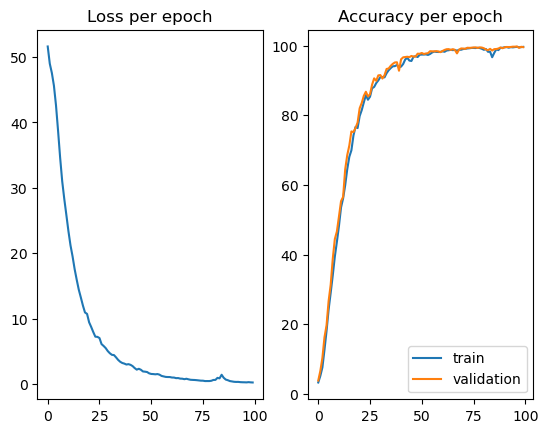

In [12]:
history = train_loop(
    train_loader=train_sub_loader, 
    validation_loader= train_sub_loader,
    model=model, 
    loss_map=nn.CrossEntropyLoss(),
    validation_map=validate,
    lr=0.001,
    epochs=100)

print("Training phase")
show_history(history)